## Sentiment and Time Series on ProjectTweets dataset.

Version control link: https://github.com/mariadominguez2023/CA2-BDS-ADA.git

In [1]:
#Import the libraries
import pandas as pd
import numpy as np
import seaborn as sns
import re
import string
from string import punctuation
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
import datetime

#Libraries for visualization and sentiment analysis
import matplotlib as mpl
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
plt.rcParams['lines.linewidth'] = 1.5
%matplotlib inline
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import CountVectorizer
nltk.download('vader_lexicon')
from nltk.sentiment.vader import SentimentIntensityAnalyzer as SIA

#Deep learning model libraries
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, Dropout
from tensorflow.keras.callbacks import EarlyStopping

#Time series and forecasting libraries
from skforecast.ForecasterAutoreg import ForecasterAutoreg
from skforecast.ForecasterAutoregCustom import ForecasterAutoregCustom
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from skforecast.model_selection import grid_search_forecaster

import warnings
warnings.filterwarnings("ignore")

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\maria\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\maria\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


## **Data Preparation**

In [2]:
#Checking data head first 5 rows
data = pd.read_csv('ProjectTweets.csv')
data.head()

,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, that's a bummer. You shoulda got David Carr of Third Day to do it. ;D"
0,1,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
1,2,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
2,3,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
3,4,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."
4,5,1467811372,Mon Apr 06 22:20:00 PDT 2009,NO_QUERY,joy_wolf,@Kwesidei not the whole crew


In [3]:
#Shape of the dataframe
data.shape

(1599999, 6)

In [4]:
#Checking the type of data
#data.info()

In [5]:
# Data preparation
# ==============================================================================
data = data.rename(columns={'1467810369': 'Tweet_ID', 'Mon Apr 06 22:19:45 PDT 2009': 'date','_TheSpecialOne_': 'Twitter_User'})
data.head()

,0,Tweet_ID,date,NO_QUERY,Twitter_User,"@switchfoot http://twitpic.com/2y1zl - Awww, that's a bummer. You shoulda got David Carr of Third Day to do it. ;D"
0,1,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
1,2,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
2,3,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
3,4,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."
4,5,1467811372,Mon Apr 06 22:20:00 PDT 2009,NO_QUERY,joy_wolf,@Kwesidei not the whole crew


In [6]:
#Changing the name of last column containing the text data.

def format_data(data):

  last_col = str(data.columns[-1])
  #first_col = str(data.columns[0])

  data.rename(columns = {last_col: 'text'}, inplace=True) 

  # Change 0, 2, 4 to negative, neutral and positive
 # labels = {0: 'negative', 2: 'neutral', 4: 'positive'}
  #data['polarity'] = data['polarity'].map(labels)

  # Get only the two columns
  return data[['Tweet_ID','date','Twitter_User','text']]

In [7]:
#Checking dataframe
data = format_data(data)
data.head(10)

,Tweet_ID,date,Twitter_User,text
0,1467810672,Mon Apr 06 22:19:49 PDT 2009,scotthamilton,is upset that he can't update his Facebook by ...
1,1467810917,Mon Apr 06 22:19:53 PDT 2009,mattycus,@Kenichan I dived many times for the ball. Man...
2,1467811184,Mon Apr 06 22:19:57 PDT 2009,ElleCTF,my whole body feels itchy and like its on fire
3,1467811193,Mon Apr 06 22:19:57 PDT 2009,Karoli,"@nationwideclass no, it's not behaving at all...."
4,1467811372,Mon Apr 06 22:20:00 PDT 2009,joy_wolf,@Kwesidei not the whole crew
5,1467811592,Mon Apr 06 22:20:03 PDT 2009,mybirch,Need a hug
6,1467811594,Mon Apr 06 22:20:03 PDT 2009,coZZ,@LOLTrish hey long time no see! Yes.. Rains a...
7,1467811795,Mon Apr 06 22:20:05 PDT 2009,2Hood4Hollywood,@Tatiana_K nope they didn't have it
8,1467812025,Mon Apr 06 22:20:09 PDT 2009,mimismo,@twittera que me muera ?
9,1467812416,Mon Apr 06 22:20:16 PDT 2009,erinx3leannexo,spring break in plain city... it's snowing


## Data cleaning

The data has to be cleaning before making any further analysis.

In [8]:
#Checking the type of data
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1599999 entries, 0 to 1599998
Data columns (total 4 columns):
 #   Column        Non-Null Count    Dtype 
---  ------        --------------    ----- 
 0   Tweet_ID      1599999 non-null  int64 
 1   date          1599999 non-null  object
 2   Twitter_User  1599999 non-null  object
 3   text          1599999 non-null  object
dtypes: int64(1), object(3)
memory usage: 48.8+ MB


In [9]:
#Remove twitter handlers
data.text = data.text.apply(lambda x:re.sub('@[^\s]+','',x))

In [10]:
#Remove URLS from text
data.text = data.text.apply(lambda x:re.sub(r"http\S+", "", x))

In [11]:
#Remove hashtags
data.text = data.text.apply(lambda x:re.sub(r'\B#\S+','',x))

In [12]:
#Remove all the special characters
data.text = data.text.apply(lambda x:' '.join(re.findall(r'\w+', x)))

In [13]:
#Remove all single characters
data.text = data.text.apply(lambda x:re.sub(r'\s+[a-zA-Z]\s+', '', x))

In [14]:
# Multiple spaces are being substituided with single space
data.text = data.text.apply(lambda x:re.sub(r'\s+', ' ', x, flags=re.I))

In [16]:
#Checking data set after being cleaned on previous steps
data.head()

,Tweet_ID,date,Twitter_User,text
0,1467810672,Mon Apr 06 22:19:49 PDT 2009,scotthamilton,is upset that he canupdate his Facebook by tex...
1,1467810917,Mon Apr 06 22:19:53 PDT 2009,mattycus,I dived many times for the ball Managed to sav...
2,1467811184,Mon Apr 06 22:19:57 PDT 2009,ElleCTF,my whole body feels itchy and like its on fire
3,1467811193,Mon Apr 06 22:19:57 PDT 2009,Karoli,no itnot behaving at allm mad why amhere becau...
4,1467811372,Mon Apr 06 22:20:00 PDT 2009,joy_wolf,not the whole crew


In [15]:
#Creating a new column "tweet_mode" using lambda function
data["tweet_mode"]=data["text"].apply(lambda x: " ".join(x.lower() for x in x.split()))

In [16]:
data.head()

,Tweet_ID,date,Twitter_User,text,tweet_mode
0,1467810672,Mon Apr 06 22:19:49 PDT 2009,scotthamilton,is upset that he canupdate his Facebook by tex...,is upset that he canupdate his facebook by tex...
1,1467810917,Mon Apr 06 22:19:53 PDT 2009,mattycus,I dived many times for the ball Managed to sav...,i dived many times for the ball managed to sav...
2,1467811184,Mon Apr 06 22:19:57 PDT 2009,ElleCTF,my whole body feels itchy and like its on fire,my whole body feels itchy and like its on fire
3,1467811193,Mon Apr 06 22:19:57 PDT 2009,Karoli,no itnot behaving at allm mad why amhere becau...,no itnot behaving at allm mad why amhere becau...
4,1467811372,Mon Apr 06 22:20:00 PDT 2009,joy_wolf,not the whole crew,not the whole crew


In [17]:
#Extracting sentiment from text, creating three new columns, Positive, Neutral and Negative sentiment.
#sid = SIA()
#data['sentiments']           = data['text'].apply(lambda x: sid.polarity_scores(' '.join(re.findall(r'\w+',x.lower()))))
#data['Positive Sentiment']   = data['sentiments'].apply(lambda x: x['pos']+1*(10**-6)) 
#data['Neutral Sentiment']    = data['sentiments'].apply(lambda x: x['neu']+1*(10**-6))
#data['Negative Sentiment']   = data['sentiments'].apply(lambda x: x['neg']+1*(10**-6))

#data.drop(columns=['sentiments'],inplace=True)
#data.head()

In [18]:
#checking null values
data.isnull().sum()

Tweet_ID        0
date            0
Twitter_User    0
text            0
tweet_mode      0
dtype: int64

In [22]:
#Number of Words
#data['Number_of_Words'] = data.text.apply(lambda x:len(x.split(' ')))

In [23]:
#Average Word Length
#data['Mean_Word_Length'] = data.text.apply(lambda x:np.round(np.mean([len(w) for w in x.split(' ')]),2) )
#data.head()

In [24]:
#Visualizing Sentimient Distribution 
#import random
#import matplotlib.pyplot as plt
#import seaborn as sns
#sns.set_style('darkgrid')
#plt.rc('figure',figsize=(17,13))
#plt.subplot(2,1,1)
#plt.title('Sentiments Distributed across ProjecTweets',fontsize=16,fontweight='bold')
#sns.kdeplot(data['Negative Sentiment'],bw=0.1)
#sns.kdeplot(data['Positive Sentiment'],bw=0.1)
#sns.kdeplot(data['Neutral Sentiment'],bw=0.1)

#Cumulative Distribution function
#plt.subplot(2,1,2)
#plt.title('Sentiments CDF Across ProjecTweets',fontsize=16,fontweight='bold')
#sns.kdeplot(data['Negative Sentiment'],bw=0.1,cumulative=True)
#sns.kdeplot(data['Positive Sentiment'],bw=0.1,cumulative=True)
#sns.kdeplot(data['Neutral Sentiment'],bw=0.1,cumulative=True)
#plt.xlabel('Sentiment Value',fontsize=19)
#plt.show()

In [25]:
#pip install textblob

In [26]:
#Importing textblow library
from textblob import TextBlob

In [27]:
# Sentiment can be also extracted using this lambda function, which extract the emotional value, the sentiment from this text
#first number is the sentimient, second is the number times this words is talked about
data["tweet_mode"][:5].apply(lambda x : TextBlob(x).sentiment)

0       (0.0, 0.0)
1       (0.5, 0.5)
2       (0.2, 0.4)
3    (-0.625, 1.0)
4       (0.2, 0.4)
Name: tweet_mode, dtype: object

In [28]:
#creating a new column "sentiment"
#going through each of the comments and extracting the sentiment analysis stored into it
data["sentiment"]=data["tweet_mode"].apply(lambda x: TextBlob(x).sentiment[0])

In [29]:
#Checking the data after Sentiment column has been created
data.head()

,Tweet_ID,date,Twitter_User,text,tweet_mode,Number_of_Words,sentiment
0,1467810672,Mon Apr 06 22:19:49 PDT 2009,scotthamilton,is upset that he canupdate his Facebook by tex...,is upset that he canupdate his facebook by tex...,18,0.000
1,1467810917,Mon Apr 06 22:19:53 PDT 2009,mattycus,I dived many times for the ball Managed to sav...,i dived many times for the ball managed to sav...,17,0.500
2,1467811184,Mon Apr 06 22:19:57 PDT 2009,ElleCTF,my whole body feels itchy and like its on fire,my whole body feels itchy and like its on fire,10,0.200
3,1467811193,Mon Apr 06 22:19:57 PDT 2009,Karoli,no itnot behaving at allm mad why amhere becau...,no itnot behaving at allm mad why amhere becau...,13,-0.625
4,1467811372,Mon Apr 06 22:20:00 PDT 2009,joy_wolf,not the whole crew,not the whole crew,4,0.200


In [29]:
#import numpy as np
#Applying lambda function to categorise the sentimente of the text either "negative" or positive.
data['sentiment_score'] = data['sentiment'].apply(lambda x: 'Positive' if x > 0.2 else('Neutral' if x == 0.2 else 'Negative'))
#df['Polarity_Rating'] = df['Rating'].apply(lambda x: 'Positive' if x > 3 else('Neutral' if x == 3  else 'Negative'))

In [30]:
data.head()

,Tweet_ID,date,Twitter_User,text,tweet_mode,sentiment,sentiment_score
0,1467810672,Mon Apr 06 22:19:49 PDT 2009,scotthamilton,is upset that he canupdate his Facebook by tex...,is upset that he canupdate his facebook by tex...,0.000,Negative
1,1467810917,Mon Apr 06 22:19:53 PDT 2009,mattycus,I dived many times for the ball Managed to sav...,i dived many times for the ball managed to sav...,0.500,Positive
2,1467811184,Mon Apr 06 22:19:57 PDT 2009,ElleCTF,my whole body feels itchy and like its on fire,my whole body feels itchy and like its on fire,0.200,Neutral
3,1467811193,Mon Apr 06 22:19:57 PDT 2009,Karoli,no itnot behaving at allm mad why amhere becau...,no itnot behaving at allm mad why amhere becau...,-0.625,Negative
4,1467811372,Mon Apr 06 22:20:00 PDT 2009,joy_wolf,not the whole crew,not the whole crew,0.200,Neutral


In [31]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1599999 entries, 0 to 1599998
Data columns (total 7 columns):
 #   Column           Non-Null Count    Dtype  
---  ------           --------------    -----  
 0   Tweet_ID         1599999 non-null  int64  
 1   date             1599999 non-null  object 
 2   Twitter_User     1599999 non-null  object 
 3   text             1599999 non-null  object 
 4   tweet_mode       1599999 non-null  object 
 5   sentiment        1599999 non-null  float64
 6   sentiment_score  1599999 non-null  object 
dtypes: float64(1), int64(1), object(5)
memory usage: 85.4+ MB


**Plot the Sentiment_score visualization graph**

<Axes: xlabel='sentiment_score', ylabel='count'>

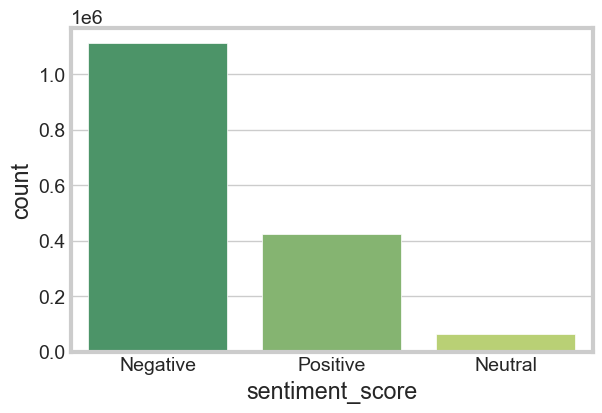

In [34]:
plt.figure(figsize=(6, 4))
sns.set_style('whitegrid')
sns.countplot(x='sentiment_score',data=data, palette='summer')

**Data Preprocessing**

It will used a sample of 9,000 

In [35]:
data_Positive = data[data['sentiment_score'] == 'Positive'][0:9000] 
data_Neutral = data[data['sentiment_score'] == 'Neutral']
data_Negative = data[data['sentiment_score'] == 'Negative']

**Sample negative and neutral polarity dataset and create final dataframe**

In [36]:
data_Neutral_final = data_Neutral.sample(9000, replace=True)
data_Negative_final = data_Negative.sample(9000, replace=True)
data_sample = pd.concat([data_Positive, data_Neutral_final, data_Negative_final], axis=0)

In [37]:
data_sample.head()

,Tweet_ID,date,Twitter_User,text,tweet_mode,Positive Sentiment,Neutral Sentiment,Negative Sentiment,Number_of_Words,Mean_Word_Length,sentiment,sentiment_score
1,1467810917,Mon Apr 06 22:19:53 PDT 2009,mattycus,I dived many times for the ball Managed to sav...,i dived many times for the ball managed to sav...,0.176001,0.824001,0.000001,17,3.53,0.500000,Positive
17,1467813579,Mon Apr 06 22:20:31 PDT 2009,starkissed,ahh ive always wanted to see rent love the sou...,ahh ive always wanted to see rent love the sou...,0.318001,0.682001,0.000001,10,4.40,0.500000,Positive
19,1467813985,Mon Apr 06 22:20:37 PDT 2009,quanvu,i was out most of the day so didnget much done,i was out most of the day so didnget much done,0.000001,1.000001,0.000001,11,3.27,0.350000,Positive
38,1467818007,Mon Apr 06 22:21:39 PDT 2009,Anthony_Nguyen,Bed Class 8 12 Work 12 3 Gym 3 5 or 6 Then cla...,bed class 8 12 work 12 3 gym 3 5 or 6 then cla...,0.000001,1.000001,0.000001,23,3.39,0.800000,Positive
44,1467819650,Mon Apr 06 22:22:05 PDT 2009,antzpantz,Yaym happy for you with your job But that also...,yaym happy for you with your job but that also...,0.128001,0.872001,0.000001,17,3.59,0.316667,Positive


In [38]:
data_sample.shape

(27000, 12)

**Text Preprocessing**

In [39]:
def get_text_processing(text):
    stpword = stopwords.words('english')
    no_punctuation = [char for char in text if char not in string.punctuation]
    no_punctuation = ''.join(no_punctuation)
    return ' '.join([word for word in no_punctuation.split() if word.lower() not in stpword])

**Apply the method "get_text_processing" into column review text**

In [40]:
data_sample['Project_tweets'] = data_sample['tweet_mode'].apply(get_text_processing)
data_sample.head()

,Tweet_ID,date,Twitter_User,text,tweet_mode,Positive Sentiment,Neutral Sentiment,Negative Sentiment,Number_of_Words,Mean_Word_Length,sentiment,sentiment_score,Project_tweets
1,1467810917,Mon Apr 06 22:19:53 PDT 2009,mattycus,I dived many times for the ball Managed to sav...,i dived many times for the ball managed to sav...,0.176001,0.824001,0.000001,17,3.53,0.500000,Positive,dived many times ball managed save 50 rest go ...
17,1467813579,Mon Apr 06 22:20:31 PDT 2009,starkissed,ahh ive always wanted to see rent love the sou...,ahh ive always wanted to see rent love the sou...,0.318001,0.682001,0.000001,10,4.40,0.500000,Positive,ahh ive always wanted see rent love soundtrack
19,1467813985,Mon Apr 06 22:20:37 PDT 2009,quanvu,i was out most of the day so didnget much done,i was out most of the day so didnget much done,0.000001,1.000001,0.000001,11,3.27,0.350000,Positive,day didnget much done
38,1467818007,Mon Apr 06 22:21:39 PDT 2009,Anthony_Nguyen,Bed Class 8 12 Work 12 3 Gym 3 5 or 6 Then cla...,bed class 8 12 work 12 3 gym 3 5 or 6 then cla...,0.000001,1.000001,0.000001,23,3.39,0.800000,Positive,bed class 8 12 work 12 3 gym 3 5 6 class 6 10 ...
44,1467819650,Mon Apr 06 22:22:05 PDT 2009,antzpantz,Yaym happy for you with your job But that also...,yaym happy for you with your job but that also...,0.128001,0.872001,0.000001,17,3.59,0.316667,Positive,yaym happy job also means less time


**Visualize Project tweets with sentiment score**

In [41]:
data_new = data_sample[['Project_tweets', 'sentiment_score']]
data_new.head()

,Project_tweets,sentiment_score
1,dived many times ball managed save 50 rest go ...,Positive
17,ahh ive always wanted see rent love soundtrack,Positive
19,day didnget much done,Positive
38,bed class 8 12 work 12 3 gym 3 5 6 class 6 10 ...,Positive
44,yaym happy job also means less time,Positive


**Apply One hot encoding on negative, neutral, and positive**

In [42]:
one_hot = pd.get_dummies(data_sample["sentiment_score"])
data_new.drop(['sentiment_score'],axis=1,inplace=True)
data_score = pd.concat([data_new,one_hot],axis=1)
data_score.head()

,Project_tweets,Negative,Neutral,Positive
1,dived many times ball managed save 50 rest go ...,0,0,1
17,ahh ive always wanted see rent love soundtrack,0,0,1
19,day didnget much done,0,0,1
38,bed class 8 12 work 12 3 gym 3 5 6 class 6 10 ...,0,0,1
44,yaym happy job also means less time,0,0,1


**Apply Train Test Split**

In [43]:
X = data_score['Project_tweets'].values
y = data_score.drop('Project_tweets', axis=1).values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=42)

In [44]:
X

array(['dived many times ball managed save 50 rest go bounds',
       'ahh ive always wanted see rent love soundtrack',
       'day didnget much done', ...,
       'school culinary hair comfirmation dinner',
       'yup apparently pain side gets worsehave go doctors hospital fail',
       'yay josie amazingg silly'], dtype=object)

In [45]:
#y

**Apply vectorization**

In [46]:
vect = CountVectorizer()
X_train = vect.fit_transform(X_train)
X_test = vect.transform(X_test)

**Apply frequency, inverse document frequency:**

In [47]:
tfidf = TfidfTransformer()
X_train = tfidf.fit_transform(X_train)
X_test = tfidf.transform(X_test)
X_train = X_train.toarray()
X_test = X_test.toarray()

**Build Neural Network model by adding different layers**

In [48]:
model = Sequential()

model.add(Dense(units=1000,activation='relu'))
model.add(Dropout(0.5))

model.add(Dense(units=4000,activation='relu'))
model.add(Dropout(0.5))

model.add(Dense(units=500,activation='relu'))
model.add(Dropout(0.5))

model.add(Dense(units=3, activation='softmax'))

opt=tf.keras.optimizers.Adam(learning_rate=0.001)
model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])

early_stop = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=2)

**Fit the Model**

In [49]:
model.fit(x=X_train, y=y_train, batch_size=256, epochs=100, validation_data=(X_test, y_test), verbose=0, callbacks=early_stop)

Epoch 3: early stopping


**Evaluation of Model**

In [50]:
model_score = model.evaluate(X_test, y_test, batch_size=64, verbose=0)
print('Test accuracy:', model_score[1]) # 0.81 previous accuracy

Test accuracy: 0.8260493874549866


**Prediction**

In [51]:
preds = model.predict(X_test)
preds

254/254 [==============================] - 8s 29ms/step


array([[7.7539247e-01, 1.1171087e-03, 2.2349054e-01],
       [9.9372500e-01, 3.6497999e-03, 2.6251846e-03],
       [9.5786989e-01, 3.7776379e-04, 4.1752346e-02],
       ...,
       [2.2759747e-04, 9.9903131e-01, 7.4110233e-04],
       [2.3152357e-02, 9.7433567e-01, 2.5120229e-03],
       [5.4264272e-04, 9.9937099e-01, 8.6400709e-05]], dtype=float32)

## **Times Series section**

In [30]:
#checking data head to start the time series analysis
data.head()

,Tweet_ID,date,Twitter_User,text,tweet_mode,Number_of_Words,sentiment
0,1467810672,Mon Apr 06 22:19:49 PDT 2009,scotthamilton,is upset that he canupdate his Facebook by tex...,is upset that he canupdate his facebook by tex...,18,0.000
1,1467810917,Mon Apr 06 22:19:53 PDT 2009,mattycus,I dived many times for the ball Managed to sav...,i dived many times for the ball managed to sav...,17,0.500
2,1467811184,Mon Apr 06 22:19:57 PDT 2009,ElleCTF,my whole body feels itchy and like its on fire,my whole body feels itchy and like its on fire,10,0.200
3,1467811193,Mon Apr 06 22:19:57 PDT 2009,Karoli,no itnot behaving at allm mad why amhere becau...,no itnot behaving at allm mad why amhere becau...,13,-0.625
4,1467811372,Mon Apr 06 22:20:00 PDT 2009,joy_wolf,not the whole crew,not the whole crew,4,0.200


In [31]:
#verify the shape of the data
data.shape

(1599999, 7)

In [32]:
#data['Tweet_ID'].duplicated()

In [33]:
#data.sentiment.value_counts()

In [34]:
#data.info()

In [35]:
# Changing the column data to datetime64[ns] format
data['date'] = data.date.astype('datetime64[ns]')
data.head()

,Tweet_ID,date,Twitter_User,text,tweet_mode,Number_of_Words,sentiment
0,1467810672,2009-04-06 22:19:49,scotthamilton,is upset that he canupdate his Facebook by tex...,is upset that he canupdate his facebook by tex...,18,0.000
1,1467810917,2009-04-06 22:19:53,mattycus,I dived many times for the ball Managed to sav...,i dived many times for the ball managed to sav...,17,0.500
2,1467811184,2009-04-06 22:19:57,ElleCTF,my whole body feels itchy and like its on fire,my whole body feels itchy and like its on fire,10,0.200
3,1467811193,2009-04-06 22:19:57,Karoli,no itnot behaving at allm mad why amhere becau...,no itnot behaving at allm mad why amhere becau...,13,-0.625
4,1467811372,2009-04-06 22:20:00,joy_wolf,not the whole crew,not the whole crew,4,0.200


In [36]:
# Dropping the duplicates from "Tweet_ID" column
data_new = data.drop_duplicates('Tweet_ID').sort_values(by=['date'], ascending=True)

In [37]:
#Checking the shape of the new dataframe
data_new.shape

(1598314, 7)

In [38]:
# Selecting columns "Date" and "sentiment" to make a univariate dataset
data_new = data[['date', 'sentiment']]
data_new.head()

,date,sentiment
0,2009-04-06 22:19:49,0.000
1,2009-04-06 22:19:53,0.500
2,2009-04-06 22:19:57,0.200
3,2009-04-06 22:19:57,-0.625
4,2009-04-06 22:20:00,0.200


In [42]:
#Rename the dependent variable
data_new = data_new.rename(columns = {'sentiment' : 'y'})
data_new.head(5)

,y
date,
2009-04-06 22:19:49,0.000
2009-04-06 22:19:53,0.500
2009-04-06 22:19:57,0.200
2009-04-06 22:19:57,-0.625
2009-04-06 22:20:00,0.200


average sentiment per day

In [43]:
data_new = data_new.set_index('date')
data_new = data_new.sort_index()
data_new.head()

KeyError: "None of ['date'] are in the columns"

In [44]:
#Resamplying the data, with the column "y" daily to be able to see the null values in the data
daily_sentiment = data_new['y'].resample('D').mean()
daily_sentiment.head()

date
2009-04-06    0.090197
2009-04-07    0.096460
2009-04-08         NaN
2009-04-09         NaN
2009-04-10         NaN
Freq: D, Name: y, dtype: float64

In [51]:
#Checking the null valuos en data set
daily_sentiment.isnull().sum()

33

<Axes: xlabel='date'>

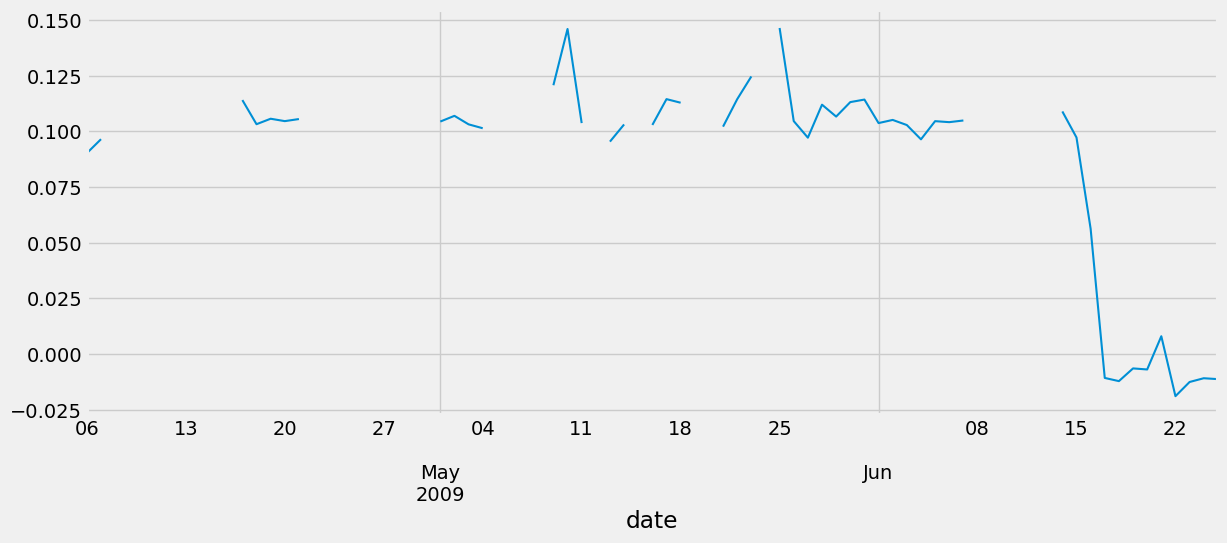

In [58]:
#Checking the dataset with all the null values
daily_sentiment.plot()

**Data Imputation**

In [60]:
# Setting dataframe data_ts
data_ts = pd.DataFrame(daily_sentiment)
print(data_ts.get("y"))

date
2009-04-06    0.090197
2009-04-07    0.096460
2009-04-08         NaN
2009-04-09         NaN
2009-04-10         NaN
                ...   
2009-06-21    0.008026
2009-06-22   -0.018874
2009-06-23   -0.012508
2009-06-24   -0.010823
2009-06-25   -0.011225
Freq: D, Name: y, Length: 81, dtype: float64


## **Spline Interpolation**

Handling Data Gaps in Time Series Using Imputation [online] Available at:  

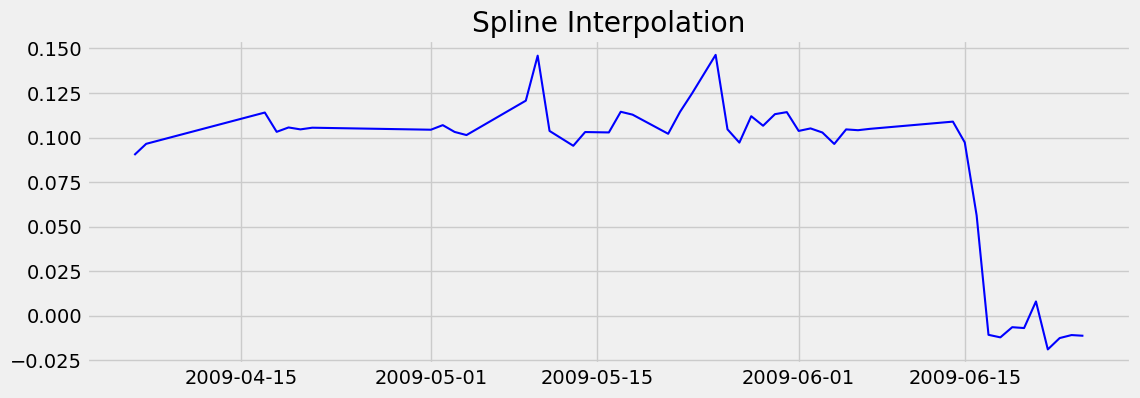

In [64]:
#The method estimates values that minimize overall curvature, thus obtaining a smooth surface passing through the input points

# setting the plot size
plt.rcParams['figure.figsize']=(12,4)
# on our data, impute the missing values using the interpolation techniques and specifically, the lineare method
data_ts['y_Spline']= data_ts['y'].interpolate(option='spline', order=2)
# plot the complete dataset
plt.plot(data_ts['y_Spline'], color='blue')
# add the tittle of our plot as Linear interpolation
plt.title('Spline Interpolation')
# print the plot
plt.show()

## **Nearest Neighbor**

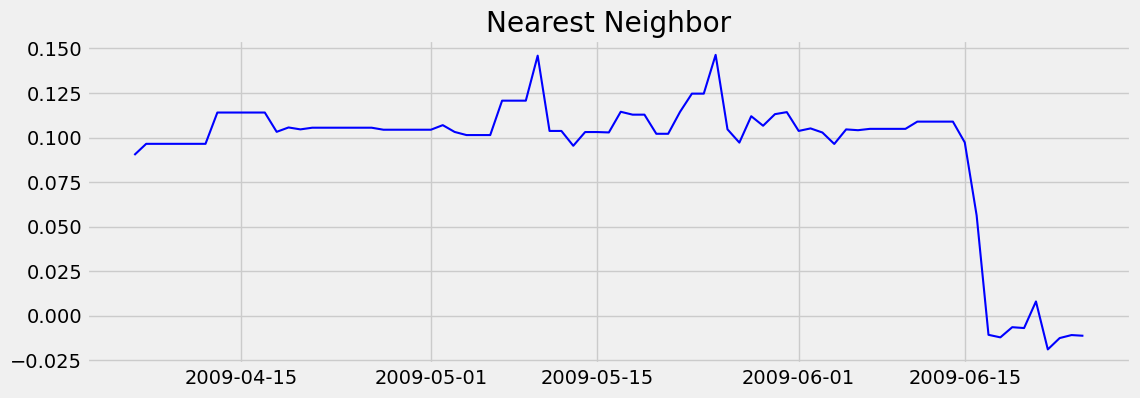

In [66]:
#df[...].interpolate(method='nearest')
# Nearest Neighbor

# setting the plot size
plt.rcParams['figure.figsize']=(12,4)
# on our data, impute the missing values using the interpolation techniques and specifically, the lineare method
data_ts['y_nearest']= data_ts['y'].interpolate(method='nearest', order=2)
# plot the complete dataset
plt.plot(data_ts['y_nearest'], color='blue')
# add the tittle of our plot as Linear interpolation
plt.title('Nearest Neighbor')
# print the plot
plt.show()

## **Polynomial Imputation**

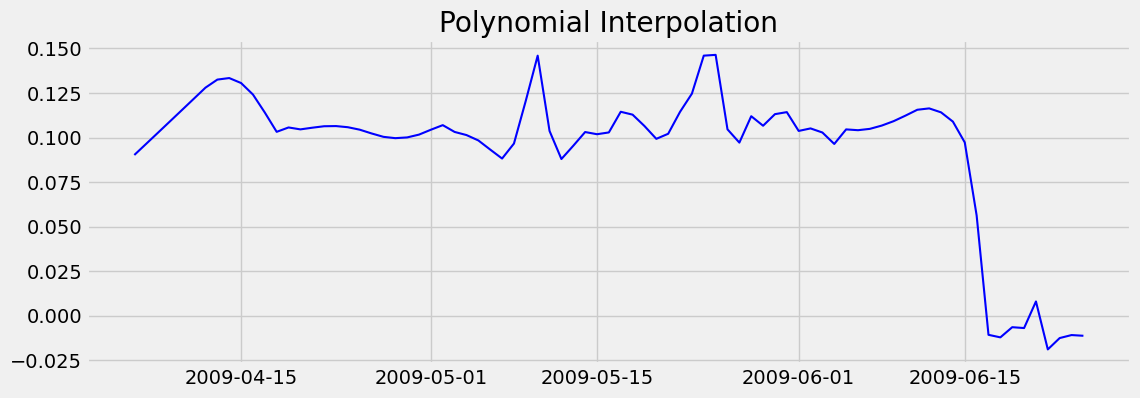

In [76]:
#df[...].interpolate(method='polynomial', order=2)
# setting the plot size
plt.rcParams['figure.figsize']=(12,4)
# on our data, impute the missing values using the interpolation techniques and specifically, the lineare method
data_ts['y_Polynomial']= data_ts['y'].interpolate(method='polynomial', order=2)
# plot the complete dataset
plt.plot(data_ts['y_Polynomial'], color='blue')
# add the tittle of our plot as Linear interpolation
plt.title('Polynomial Interpolation')
# print the plot
plt.show()

In [ ]:
#

## **KNN Imputation**

In [77]:
#KNN(k = 5).fit_transform(df)[:, 0]

# setting the plot size
#plt.rcParams['figure.figsize']=(12,4)
# on our data, impute the missing values using the interpolation techniques and specifically, the lineare method
#data_ts['y_KNN']= data_ts['y'].interpolate(method='nearest', order=2)
#KNN = KNN(K = 5).fit_transform(data_ts)[:,0]
# plot the complete dataset
#plt.plot(data_ts['y_KNN'], color='blue')
# add the tittle of our plot as Linear interpolation
#plt.title('KNN Imputation')
# print the plot
#plt.show()

In [78]:
data_ts.index

DatetimeIndex(['2009-04-06', '2009-04-07', '2009-04-08', '2009-04-09',
               '2009-04-10', '2009-04-11', '2009-04-12', '2009-04-13',
               '2009-04-14', '2009-04-15', '2009-04-16', '2009-04-17',
               '2009-04-18', '2009-04-19', '2009-04-20', '2009-04-21',
               '2009-04-22', '2009-04-23', '2009-04-24', '2009-04-25',
               '2009-04-26', '2009-04-27', '2009-04-28', '2009-04-29',
               '2009-04-30', '2009-05-01', '2009-05-02', '2009-05-03',
               '2009-05-04', '2009-05-05', '2009-05-06', '2009-05-07',
               '2009-05-08', '2009-05-09', '2009-05-10', '2009-05-11',
               '2009-05-12', '2009-05-13', '2009-05-14', '2009-05-15',
               '2009-05-16', '2009-05-17', '2009-05-18', '2009-05-19',
               '2009-05-20', '2009-05-21', '2009-05-22', '2009-05-23',
               '2009-05-24', '2009-05-25', '2009-05-26', '2009-05-27',
               '2009-05-28', '2009-05-29', '2009-05-30', '2009-05-31',
      

In [136]:
#data_int = data_ts['y_Polynomial']
data_int = data_ts['y_Spline']
data_int.head()

date
2009-04-06    0.090197
2009-04-07    0.096460
2009-04-08    0.098216
2009-04-09    0.099971
2009-04-10    0.101727
Freq: D, Name: y_Spline, dtype: float64

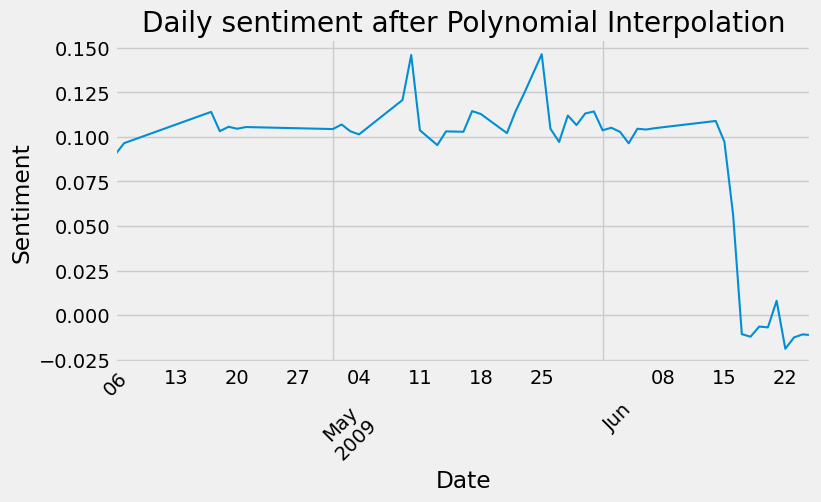

In [137]:
# Plot the time series of daily tweet count
plt.figure(figsize=(8, 4))
data_int.plot()
plt.xlabel('Date')
plt.ylabel('Sentiment')
plt.xticks(rotation=45)
plt.title('Daily sentiment after Polynomial Interpolation')
plt.show()

In [138]:
data_int.head()

date
2009-04-06    0.090197
2009-04-07    0.096460
2009-04-08    0.098216
2009-04-09    0.099971
2009-04-10    0.101727
Freq: D, Name: y_Spline, dtype: float64

In [139]:
data_int.info()

<class 'pandas.core.series.Series'>
DatetimeIndex: 81 entries, 2009-04-06 to 2009-06-25
Freq: D
Series name: y_Spline
Non-Null Count  Dtype  
--------------  -----  
81 non-null     float64
dtypes: float64(1)
memory usage: 1.3 KB


In [140]:
#df = pd.DataFrame(data_int)
#print(df.get("y_Polynomial"))
df = pd.DataFrame(data_int)
print(df.get("y_Spline"))

date
2009-04-06    0.090197
2009-04-07    0.096460
2009-04-08    0.098216
2009-04-09    0.099971
2009-04-10    0.101727
                ...   
2009-06-21    0.008026
2009-06-22   -0.018874
2009-06-23   -0.012508
2009-06-24   -0.010823
2009-06-25   -0.011225
Freq: D, Name: y_Spline, Length: 81, dtype: float64


In [141]:
#Rename the dependent variable
dataset = df.rename(columns = {'y_Spline' : 'y'})
dataset.head(5)

,y
date,
2009-04-06,0.090197
2009-04-07,0.096460
2009-04-08,0.098216
2009-04-09,0.099971
2009-04-10,0.101727


In [118]:
#dataset.head()

In [84]:
# Calulate the average sentiment per date, using Group by to calculate mean sentiment
#data_avr = data_int.groupby(['date'])['y'].mean()
#data_avr.head(30)

**Average sentiment per day**

In [73]:
# Calulate the average sentiment per date, using Group by to calculate mean sentiment
#data_avr = data.groupby(['date'])['y'].mean()
#data_avr.head(30)

date
2009-04-06    0.151068
2009-04-07    0.162788
2009-04-17    0.191261
2009-04-18    0.176722
2009-04-19    0.178647
2009-04-20    0.174721
2009-04-21    0.172930
2009-05-01    0.173448
2009-05-02    0.175681
2009-05-03    0.171344
2009-05-04    0.168644
2009-05-09    0.190686
2009-05-10    0.228915
2009-05-11    0.173852
2009-05-13    0.157905
2009-05-14    0.172869
2009-05-16    0.171059
2009-05-17    0.191369
2009-05-18    0.186213
2009-05-21    0.168556
2009-05-22    0.192281
2009-05-23    0.189715
2009-05-25    0.230008
2009-05-26    0.171050
2009-05-27    0.164963
2009-05-28    0.185674
2009-05-29    0.178223
2009-05-30    0.189710
2009-05-31    0.190949
2009-06-01    0.171531
Name: y, dtype: float64

In [74]:
#data_ts = pd.DataFrame(data_avr)
#print(data_ts.get("y"))

date
2009-04-06    0.151068
2009-04-07    0.162788
2009-04-17    0.191261
2009-04-18    0.176722
2009-04-19    0.178647
2009-04-20    0.174721
2009-04-21    0.172930
2009-05-01    0.173448
2009-05-02    0.175681
2009-05-03    0.171344
2009-05-04    0.168644
2009-05-09    0.190686
2009-05-10    0.228915
2009-05-11    0.173852
2009-05-13    0.157905
2009-05-14    0.172869
2009-05-16    0.171059
2009-05-17    0.191369
2009-05-18    0.186213
2009-05-21    0.168556
2009-05-22    0.192281
2009-05-23    0.189715
2009-05-25    0.230008
2009-05-26    0.171050
2009-05-27    0.164963
2009-05-28    0.185674
2009-05-29    0.178223
2009-05-30    0.189710
2009-05-31    0.190949
2009-06-01    0.171531
2009-06-02    0.175083
2009-06-03    0.172689
2009-06-04    0.166500
2009-06-05    0.175158
2009-06-06    0.176780
2009-06-07    0.179019
2009-06-14    0.177068
2009-06-15    0.164976
2009-06-16    0.093837
2009-06-17   -0.017302
2009-06-18   -0.021588
2009-06-19   -0.009523
2009-06-20   -0.013703
2009-0

In [52]:
#data_avr = data.groupby(['2009-04-06'])['y'].mean()
#data_avr.head(30)

In [79]:
#data = data.set_index('date')
#data = data.sort_index()
#data.head()

KeyError: "None of ['date'] are in the columns"

In [77]:
#data['date'] = data.date.astype('datetime64[ns]')
#data = data.set_index('date')
#data = data.sort_index()
#data.head()

In [73]:
# creating series True or False for NaN data and present data respectively. 
#nul_data = pd.isnull(data['y']) 

In [74]:
# print only the data, Customers = NaN 
#data[nul_data]

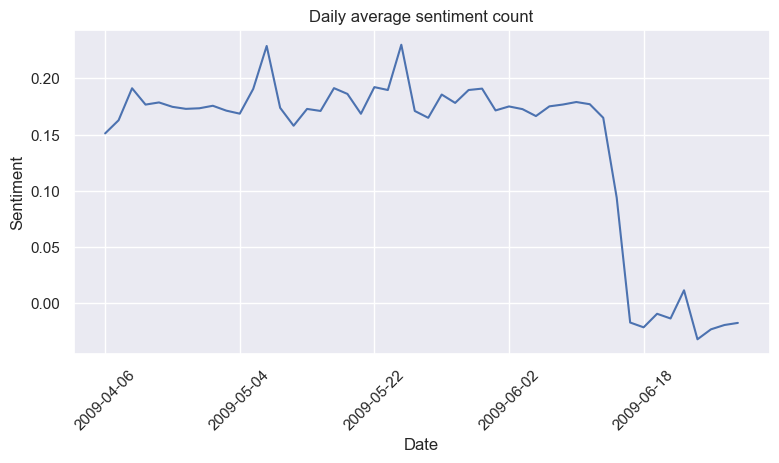

In [82]:
# Plot the time series of daily tweet count
plt.figure(figsize=(8, 4))
data_avr.plot()
plt.xlabel('Date')
plt.ylabel('Sentiment')
plt.xticks(rotation=45)
plt.title('Daily average sentiment count')
plt.show()

In [27]:
#data = pd.to_datetime(data['date'], format='%Y-%m-%d')
#data.head()

In [ ]:
#data = pd.to_datetime(data['date'], format='%Y-%m-%d')
#data.head()

In [28]:
#data['date'] = pd.to_datetime(data['date']).dt.strftime('%Y-%m-%d')# %H:%M:%S') # '%Y-%m-%d %H:%M:%S'
#data = data.set_index('date')
#data = data.asfreq('MS')
#data = data.sort_index()
#data.head()

In [29]:
#data = pd.to_datetime(data['date'], format='%Y-%m-%d')
#data.head()

In [28]:
#data = data.drop_duplicates('date').sort_values(by=['date'], ascending=True)

In [42]:
#data.shape

(774362, 1)

In [42]:
#data = pd.to_datetime(data['date'], format='%Y-%m-%d')
#data.head()

0   2009-04-06 22:19:49
1   2009-04-06 22:19:53
2   2009-04-06 22:19:57
4   2009-04-06 22:20:00
5   2009-04-06 22:20:03
Name: date, dtype: datetime64[ns]

In [54]:
#data = data.set_index('date')
#data = data.sort_index()
#data.head()

,y
date,
2009-04-06 22:19:49,0.0
2009-04-06 22:19:53,0.5
2009-04-06 22:19:57,0.2
2009-04-06 22:20:00,0.2
2009-04-06 22:20:03,0.0


In [85]:
#daily_data = daily_data.set_index('date')
#daily_data = daily_data.sort_index()
#data_ts.index

In [86]:
# Plot the time series of daily tweet count
#plt.figure(figsize=(8, 4))
#daily_data.plot()
#plt.xlabel('Date')
#plt.ylabel('Sentiment')
#plt.xticks(rotation=45)
#plt.title('Daily sentiment Count')
#plt.show()

In [87]:
#Visualizing the data
#plt.xlabel('date')
#plt.ylabel('sentiment')
#plt.plot(date)

In [88]:
#daily_data.head

In [89]:
#data_new = pd.DataFrame(daily_data)
#print(data_new.get("y"))

**Data Stationary -  Augmented Dickey–Fuller Test**

In [150]:
#Stationarity
from statsmodels.tsa.stattools import adfuller
stationarity = adfuller(dataset['y'])
#stationarity
print('Dickey Fuller p-value: %F' % stationarity[1])

Dickey Fuller p-value: 0.936275


α = 0.05

Null Hypothesis: The data is not stationary.

Alternative Hypothesis: The data is stationary.

For the data to be stationary (ie. reject the null hypothesis), the ADF test should have:

p-value <= significance level α 0.05

If the p-value is greater than the significance level then we can say that it is likely that the data is not stationary.

How do we know if we accept or reject the hypothesis? To reject the hypothesis, p-value must be less than α, which as a default is 0.05.

**P-value 0.p3 is greater than α. Ho is accepted as data is not stationary**

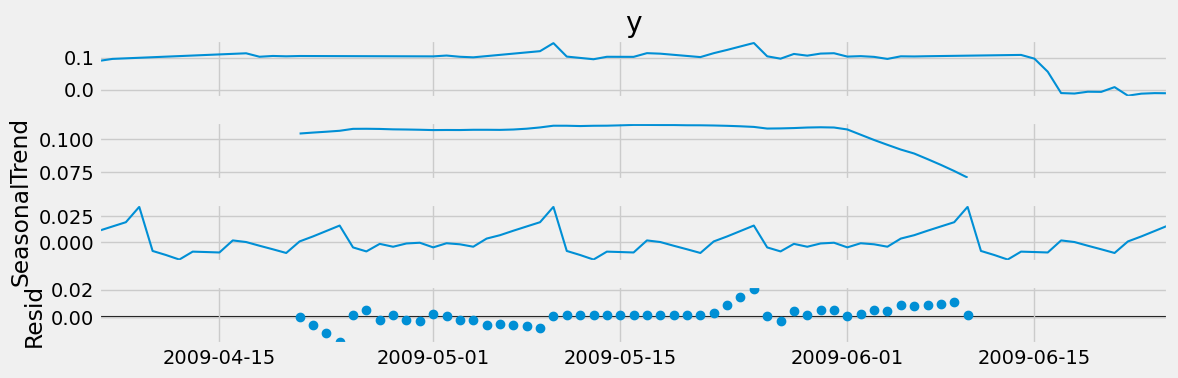

In [158]:
#Seasonal decomposition --> We use multiplicative method

from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(dataset["y"], # dependent variable
                                   model = "additive", period=31)
                                    #freq = 365 # we want to analize by yeat 
decomposition.plot();

In [120]:
#Checking null values
print(f'Number of rows with missing values: {dataset.isnull().any(axis=1).mean()}')

Number of rows with missing values: 0.0


In [121]:
#We still have null values on my dataset
dataset.isnull().sum()

y    0
dtype: int64

In [122]:
# Verify that a temporary index is complete
# ==============================================================================
(dataset.index == pd.date_range(start=dataset.index.min(),
                             end=dataset.index.max(),
                             freq=dataset.index.freq)).all()

True

**Recursive autoregressive forecasting**

Train dates : 2009-04-06 00:00:00 --- 2009-06-19 00:00:00  (n=75)
Test dates  : 2009-06-20 00:00:00 --- 2009-06-25 00:00:00  (n=6)


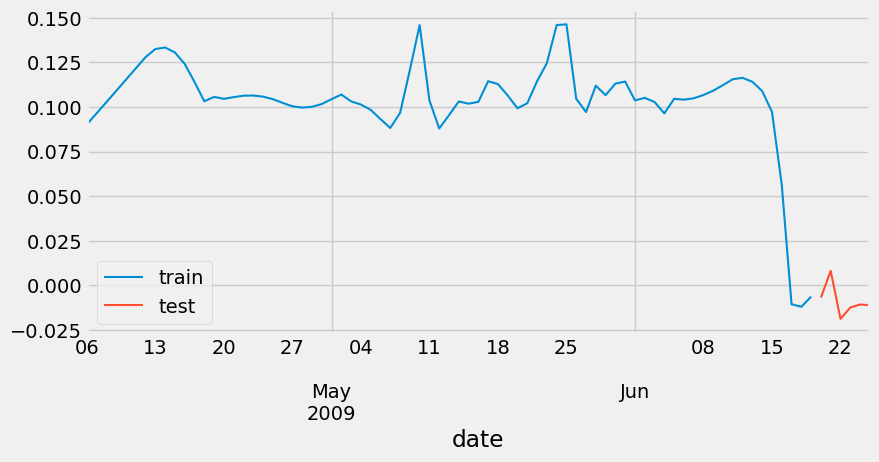

In [123]:
# Split data into train-test
# ==============================================================================
steps = 6 # 6 days to predict the 7 day 
dataset_train = dataset[:-steps]
dataset_test  = dataset[-steps:]

print(f"Train dates : {dataset_train.index.min()} --- {dataset_train.index.max()}  (n={len(dataset_train)})")
print(f"Test dates  : {dataset_test.index.min()} --- {dataset_test.index.max()}  (n={len(dataset_test)})")

fig, ax=plt.subplots(figsize=(9, 4))
dataset_train['y'].plot(ax=ax, label='train')
dataset_test['y'].plot(ax=ax, label='test')
ax.legend();

In [42]:
#pip install skforecast --user

In [125]:
# Create and train forecaster
# ==============================================================================
forecaster = ForecasterAutoreg(
                regressor = RandomForestRegressor(random_state=123),
                lags =6 # 7 months to predict the 8 day 
                )

forecaster.fit(y=dataset_train['y'])
forecaster

ForecasterAutoreg 
Regressor: RandomForestRegressor(random_state=123) 
Lags: [1 2 3 4 5 6] 
Transformer for y: None 
Transformer for exog: None 
Window size: 6 
Weight function included: False 
Differentiation order: None 
Exogenous included: False 
Type of exogenous variable: None 
Exogenous variables names: None 
Training range: [Timestamp('2009-04-06 00:00:00'), Timestamp('2009-06-19 00:00:00')] 
Training index type: DatetimeIndex 
Training index frequency: D 
Regressor parameters: {'bootstrap': True, 'ccp_alpha': 0.0, 'criterion': 'squared_error', 'max_depth': None, 'max_features': 1.0, 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 100, 'n_jobs': None, 'oob_score': False, 'random_state': 123, 'verbose': 0, 'warm_start': False} 
fit_kwargs: {} 
Creation date: 2023-11-15 22:36:48 
Last fit date: 2023-11-15 22:36:48 
Skforecast version: 0.10.1 
Python version: 3

In [126]:
# Predictions
# ==============================================================================
steps = 6 # 6 days into the future
predictions = forecaster.predict(steps=steps)
predictions.head(5)

2009-06-20   -0.000811
2009-06-21   -0.000811
2009-06-22   -0.000811
2009-06-23   -0.000811
2009-06-24   -0.000811
Freq: D, Name: pred, dtype: float64

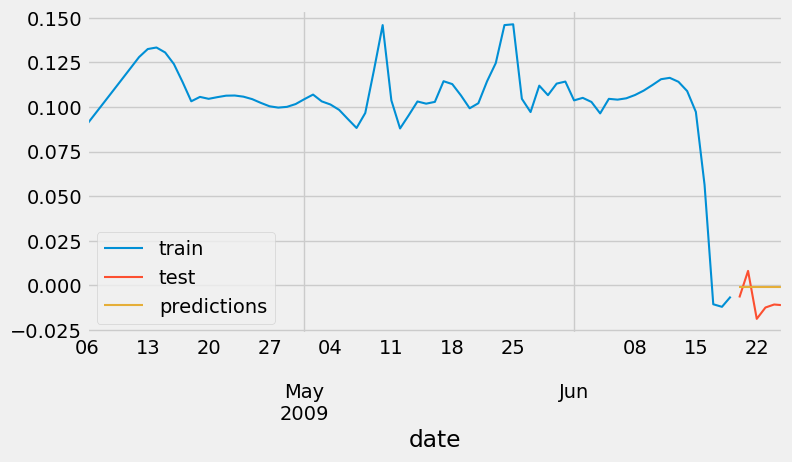

In [127]:
# Plot
# ==============================================================================
fig, ax = plt.subplots(figsize=(8, 4))
dataset_train['y'].plot(ax=ax, label='train')
dataset_test['y'].plot(ax=ax, label='test')
predictions.plot(ax=ax, label='predictions')
ax.legend();

In [128]:
# Test error
# ==============================================================================
error_mse = mean_squared_error(
                y_true = dataset_test['y'],
                y_pred = predictions
            )

print(f"Test error (mse): {error_mse}") # 345044715

Test error (mse): 0.00013113135577170795


In [143]:
# Hyperparameter Grid search
# ==============================================================================
steps = 6
forecaster = ForecasterAutoreg(
                regressor = RandomForestRegressor(random_state=123),
                lags      = 8 # This value will be replaced in the grid search
             )

# Lags used as predictors
lags_grid = [10, 20]

# Regressor's hyperparameters
param_grid = {'n_estimators': [100, 500], # number of trees
              'max_depth': [3, 5, 10]}  #depth of the tree

results_grid = grid_search_forecaster(
                        forecaster         = forecaster,
                        y                  = dataset_train['y'],
                        param_grid         = param_grid,
                        lags_grid          = lags_grid,
                        steps              = steps,
                        refit              = True,
                        metric             = 'mean_squared_error',
                        initial_train_size = int(len(dataset_train)*0.5),
                        fixed_train_size   = False,
                        return_best        = True,
                        verbose            = False
               )

Number of models compared: 12.


lags grid:   0%|          | 0/2 [00:00<?, ?it/s]

params grid:   0%|          | 0/6 [00:00<?, ?it/s]

`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20] 
  Parameters: {'max_depth': 5, 'n_estimators': 100}
  Backtesting metric: 0.0005852102362610084



In [145]:
# Grid Search results
# ==============================================================================
results_grid

,lags,params,mean_squared_error,max_depth,n_estimators
8,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","{'max_depth': 5, 'n_estimators': 100}",0.000585,5,100
10,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","{'max_depth': 10, 'n_estimators': 100}",0.000586,10,100
6,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","{'max_depth': 3, 'n_estimators': 100}",0.000589,3,100
7,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","{'max_depth': 3, 'n_estimators': 500}",0.000612,3,500
11,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","{'max_depth': 10, 'n_estimators': 500}",0.000618,10,500
9,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","{'max_depth': 5, 'n_estimators': 500}",0.000619,5,500
5,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]","{'max_depth': 10, 'n_estimators': 500}",0.000754,10,500
3,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]","{'max_depth': 5, 'n_estimators': 500}",0.000764,5,500
1,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]","{'max_depth': 3, 'n_estimators': 500}",0.000764,3,500
4,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]","{'max_depth': 10, 'n_estimators': 100}",0.000795,10,100


In [146]:
# Create and train forecaster with the best hyperparameters
# ==============================================================================
regressor = RandomForestRegressor(max_depth=5, n_estimators=100, random_state=123)
forecaster = ForecasterAutoreg(
                regressor = regressor,
                lags      = 20
             )

forecaster.fit(y=dataset_train['y'])

In [147]:
# Predictions
# ==============================================================================
predictions = forecaster.predict(steps=steps)

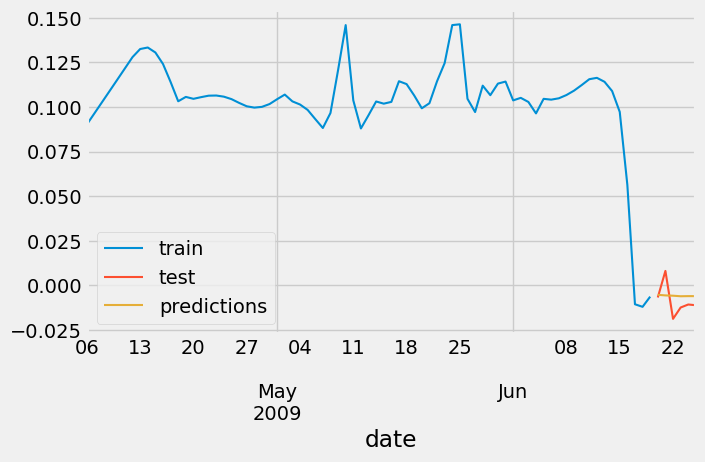

In [148]:
# Plot
# ==============================================================================
fig, ax = plt.subplots(figsize=(7, 4))
dataset_train['y'].plot(ax=ax, label='train')
dataset_test['y'].plot(ax=ax, label='test')
predictions.plot(ax=ax, label='predictions')
ax.legend();

In [149]:
# Test error
# ==============================================================================
error_mse = mean_squared_error(
                y_true = dataset_test['y'],
                y_pred = predictions
                )

print(f"Test error (mse): {error_mse}")

Test error (mse): 7.463863183476161e-05


## **30 days forecasting**

Train dates : 2009-04-06 00:00:00 --- 2009-05-27 00:00:00  (n=52)
Test dates  : 2009-05-28 00:00:00 --- 2009-06-25 00:00:00  (n=29)


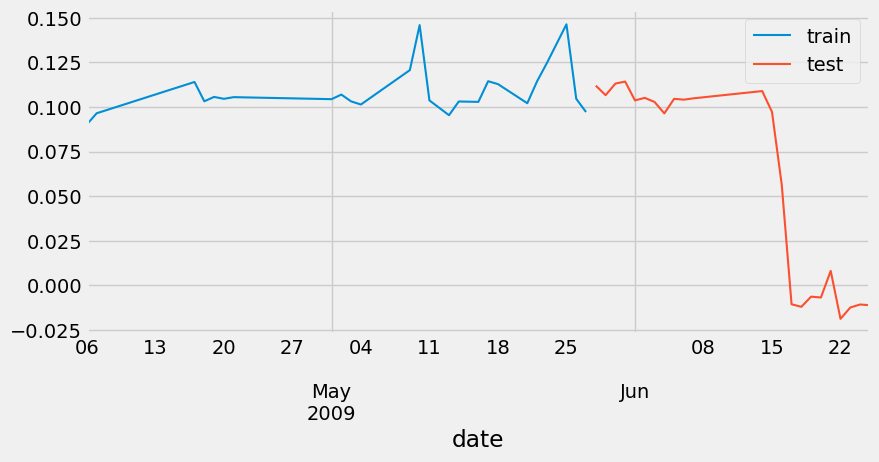

In [190]:
# Split data into train-test
# ==============================================================================
steps = 29 # 25 days to predict the 26  day 
dataset_train = dataset[:-steps]
dataset_test  = dataset[-steps:]

print(f"Train dates : {dataset_train.index.min()} --- {dataset_train.index.max()}  (n={len(dataset_train)})")
print(f"Test dates  : {dataset_test.index.min()} --- {dataset_test.index.max()}  (n={len(dataset_test)})")

fig, ax=plt.subplots(figsize=(9, 4))
dataset_train['y'].plot(ax=ax, label='train')
dataset_test['y'].plot(ax=ax, label='test')
ax.legend();

In [191]:
# Create and train forecaster
# ==============================================================================
forecaster = ForecasterAutoreg(
                regressor = RandomForestRegressor(random_state=123),
                lags =30 # 30 days to predict the 31 day 
                )

forecaster.fit(y=dataset_train['y'])
forecaster

ForecasterAutoreg 
Regressor: RandomForestRegressor(random_state=123) 
Lags: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30] 
Transformer for y: None 
Transformer for exog: None 
Window size: 30 
Weight function included: False 
Differentiation order: None 
Exogenous included: False 
Type of exogenous variable: None 
Exogenous variables names: None 
Training range: [Timestamp('2009-04-06 00:00:00'), Timestamp('2009-05-27 00:00:00')] 
Training index type: DatetimeIndex 
Training index frequency: D 
Regressor parameters: {'bootstrap': True, 'ccp_alpha': 0.0, 'criterion': 'squared_error', 'max_depth': None, 'max_features': 1.0, 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 100, 'n_jobs': None, 'oob_score': False, 'random_state': 123, 'verbose': 0, 'warm_start': False} 
fit_kwargs: {} 
Creation date: 2023-11-15 23:25:30 
L

In [192]:
# Predictions
# ==============================================================================
steps = 29 # 30 days into the future
predictions = forecaster.predict(steps=steps)
predictions.head(5)

2009-05-28    0.103168
2009-05-29    0.106280
2009-05-30    0.110750
2009-05-31    0.114543
2009-06-01    0.121959
Freq: D, Name: pred, dtype: float64

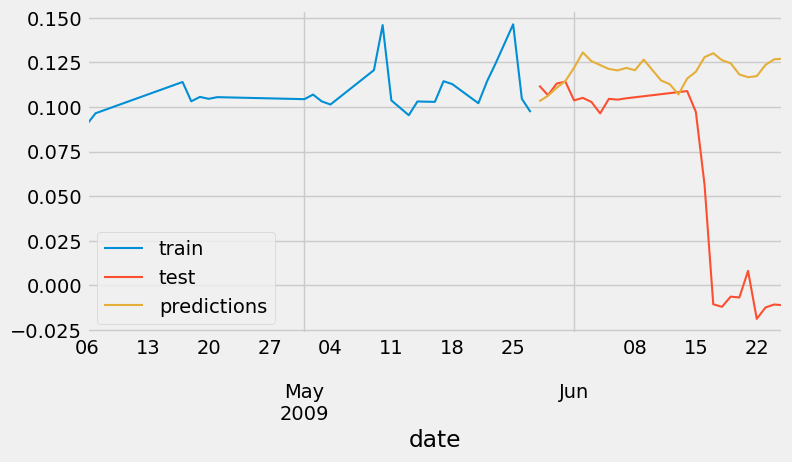

In [193]:
# Plot
# ==============================================================================
fig, ax = plt.subplots(figsize=(8, 4))
dataset_train['y'].plot(ax=ax, label='train')
dataset_test['y'].plot(ax=ax, label='test')
predictions.plot(ax=ax, label='predictions')
ax.legend();

In [194]:
# Test error
# ==============================================================================
error_mse = mean_squared_error(
                y_true = dataset_test['y'],
                y_pred = predictions
            )

print(f"Test error (mse): {error_mse}")

Test error (mse): 0.005810175834313641


In [195]:
# Hyperparameter Grid search
# ==============================================================================
steps = 29
forecaster = ForecasterAutoreg(
                regressor = RandomForestRegressor(random_state=123),
                lags      = 35 # This value will be replaced in the grid search
             )

# Lags used as predictors
lags_grid = [10, 20]

# Regressor's hyperparameters
param_grid = {'n_estimators': [100, 500], # number of trees
              'max_depth': [3, 5, 10]}  #depth of the tree

results_grid = grid_search_forecaster(
                        forecaster         = forecaster,
                        y                  = dataset_train['y'],
                        param_grid         = param_grid,
                        lags_grid          = lags_grid,
                        steps              = steps,
                        refit              = True,
                        metric             = 'mean_squared_error',
                        initial_train_size = int(len(dataset_train)*0.5),
                        fixed_train_size   = False,
                        return_best        = True,
                        verbose            = False
               )

Number of models compared: 12.


lags grid:   0%|          | 0/2 [00:00<?, ?it/s]

params grid:   0%|          | 0/6 [00:00<?, ?it/s]

`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [ 1  2  3  4  5  6  7  8  9 10] 
  Parameters: {'max_depth': 3, 'n_estimators': 500}
  Backtesting metric: 0.0002224533855391163



In [196]:
# Grid Search results
# ==============================================================================
results_grid

,lags,params,mean_squared_error,max_depth,n_estimators
1,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]","{'max_depth': 3, 'n_estimators': 500}",0.000222,3,500
0,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]","{'max_depth': 3, 'n_estimators': 100}",0.000223,3,100
7,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","{'max_depth': 3, 'n_estimators': 500}",0.000223,3,500
9,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","{'max_depth': 5, 'n_estimators': 500}",0.000223,5,500
11,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","{'max_depth': 10, 'n_estimators': 500}",0.000223,10,500
6,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","{'max_depth': 3, 'n_estimators': 100}",0.000223,3,100
8,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","{'max_depth': 5, 'n_estimators': 100}",0.000223,5,100
10,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","{'max_depth': 10, 'n_estimators': 100}",0.000223,10,100
3,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]","{'max_depth': 5, 'n_estimators': 500}",0.000224,5,500
5,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]","{'max_depth': 10, 'n_estimators': 500}",0.000224,10,500


In [197]:
# Create and train forecaster with the best hyperparameters
# ==============================================================================
regressor = RandomForestRegressor(max_depth=3, n_estimators=500, random_state=123)
forecaster = ForecasterAutoreg(
                regressor = regressor,
                lags      = 10
             )

forecaster.fit(y=dataset_train['y'])

In [198]:
# Predictions
# ==============================================================================
predictions = forecaster.predict(steps=steps)

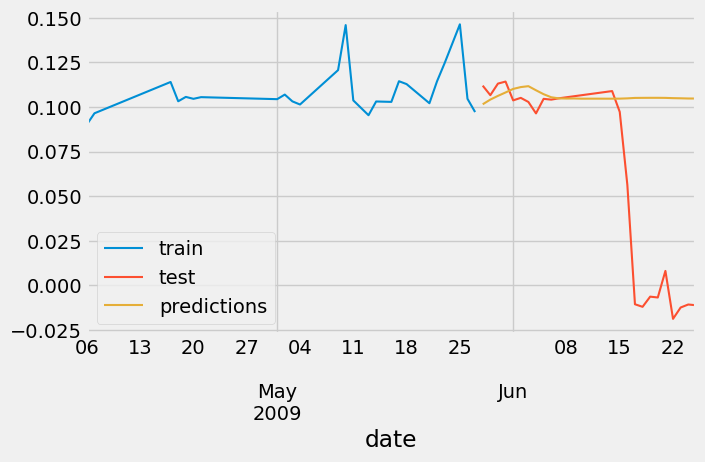

In [199]:
# Plot
# ==============================================================================
fig, ax = plt.subplots(figsize=(7, 4))
dataset_train['y'].plot(ax=ax, label='train')
dataset_test['y'].plot(ax=ax, label='test')
predictions.plot(ax=ax, label='predictions')
ax.legend();

In [200]:
# Test error
# ==============================================================================
error_mse = mean_squared_error(
                y_true = dataset_test['y'],
                y_pred = predictions
                )

print(f"Test error (mse): {error_mse}")

Test error (mse): 0.00415401570982926


## **ARMA model** 7 days prediction

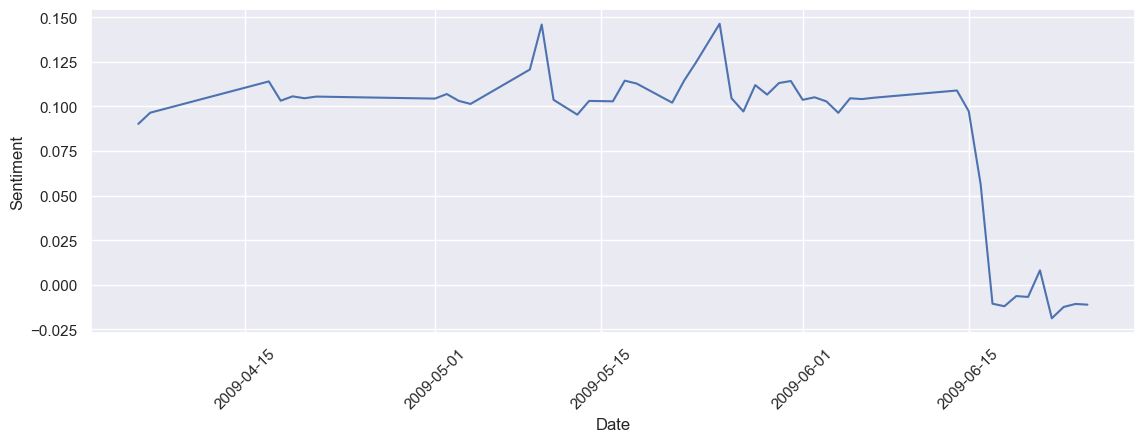

In [201]:
sns.set()
plt.ylabel('Sentiment')
plt.xlabel('Date')
plt.xticks(rotation=45)
plt.plot(dataset.index, dataset['y'], )
plt.show()

We will split our data such that everything before June 2009 will serve as training data, with 
everything after June 19 2009 becoming the testing data:

In [202]:
train = dataset[dataset.index < pd.to_datetime("2009-06-19", format='%Y-%m-%d')]
test = dataset[dataset.index >= pd.to_datetime("2009-06-19", format='%Y-%m-%d')]
test

,y
date,
2009-06-19,-0.006413
2009-06-20,-0.006888
2009-06-21,0.008026
2009-06-22,-0.018874
2009-06-23,-0.012508
2009-06-24,-0.010823
2009-06-25,-0.011225


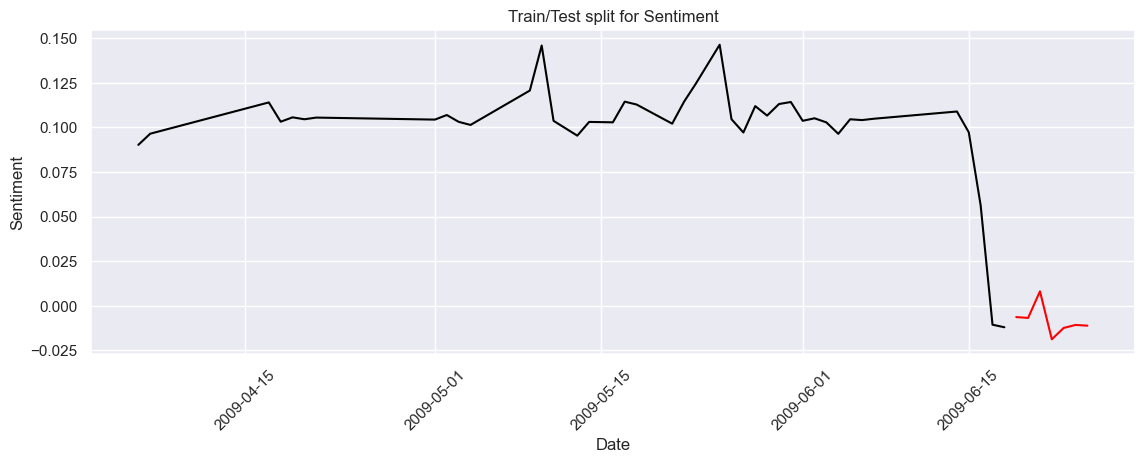

In [203]:
plt.plot(train, color = "black", label = 'Training')
plt.plot(test, color = "red", label = 'Testing')
plt.ylabel('Sentiment')
plt.xlabel('Date')
plt.xticks(rotation=45)
plt.title("Train/Test split for Sentiment")
plt.show()

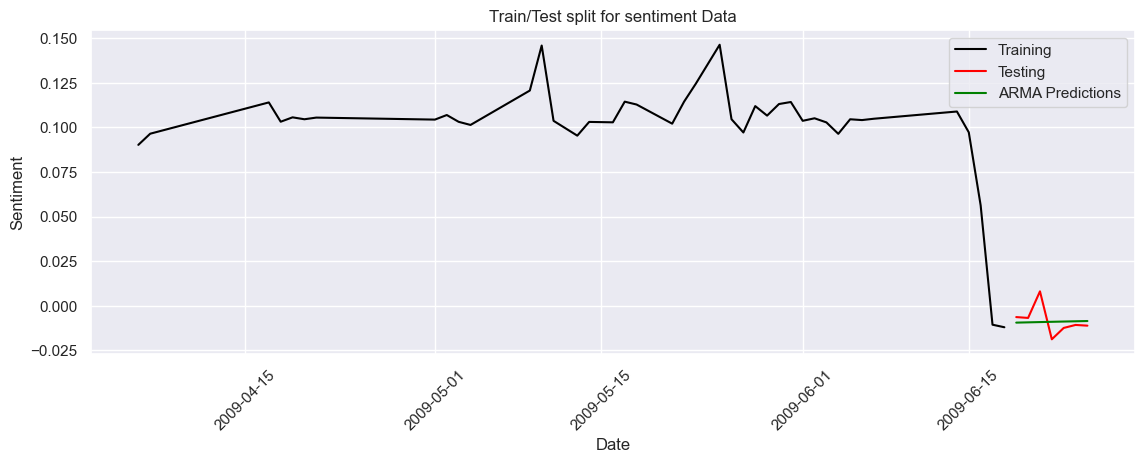

In [205]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.arima_model import ARIMA

#relax the display limits on columns and rows
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

y = train['y']

ARMAmodel = SARIMAX(y, order = (1, 0, 1))
ARMAmodel = ARMAmodel.fit()

y_pred = ARMAmodel.get_forecast(len(test.index))
y_pred_dataset = y_pred.conf_int(alpha = 0.05) 
y_pred_dataset["Predictions"] = ARMAmodel.predict(start = y_pred_dataset.index[0], 
                                             end = y_pred_dataset.index[-1])
y_pred_dataset.index = test.index
y_pred_outARMA = y_pred_dataset["Predictions"] 

plt.plot(train, color = "black", label = 'Training')
plt.plot(test, color = "red", label = 'Testing')
plt.ylabel('Sentiment')
plt.xlabel('Date')
plt.xticks(rotation=45)
plt.title("Train/Test split for sentiment Data")
plt.plot(y_pred_outARMA, color='green', label = 'ARMA Predictions')
plt.legend()
plt.show()

In [207]:
import numpy as np
from sklearn.metrics import mean_squared_error

arma_rmse = np.sqrt(mean_squared_error(test["y"].values, y_pred_dataset["Predictions"]))
print("ARMA RMSE: ",arma_rmse) # MAE

ARMA RMSE:  0.007866852501322054


In [208]:
#ARIMAmodel = SARIMAX(y, order = (2, 2, 2))
#ARIMAmodel = SARIMAX(y, order = (2, 3, 2))
ARIMAmodel = SARIMAX(y, order = (5, 4, 2))
ARIMAmodel = ARIMAmodel.fit()

y_pred = ARIMAmodel.get_forecast(len(test.index))
y_pred_dataset = y_pred.conf_int(alpha = 0.05) 
y_pred_dataset["Predictions"] = ARIMAmodel.predict(start = y_pred_dataset.index[0],
                                              end = y_pred_dataset.index[-1])
y_pred_dataset.index = test.index
y_pred_outARIMA = y_pred_dataset["Predictions"]

C:\Users\maria\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


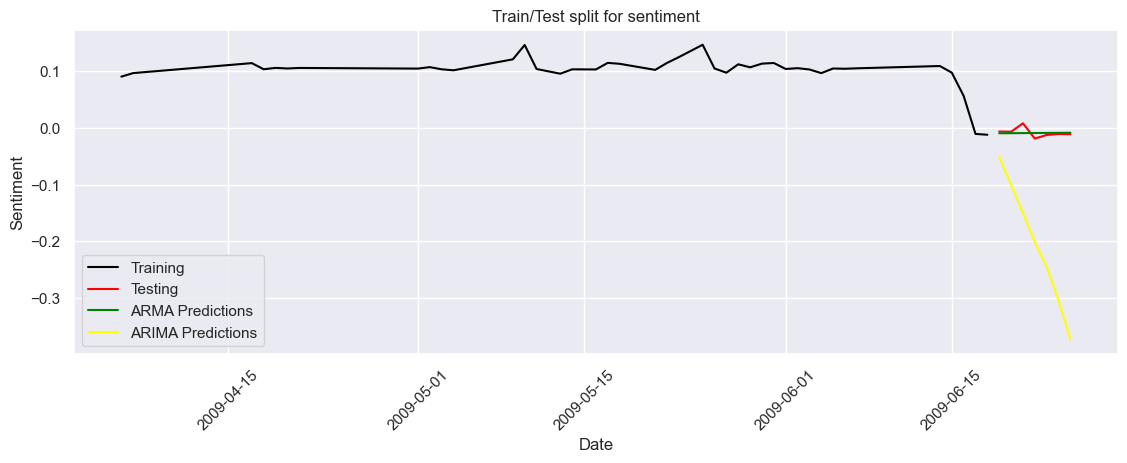

In [209]:
plt.plot(train, color = "black", label = 'Training')
plt.plot(test, color = "red", label = 'Testing')
plt.ylabel('Sentiment')
plt.xlabel('Date')
plt.xticks(rotation=45)
plt.title("Train/Test split for sentiment")
plt.plot(y_pred_outARMA, color='green', label = 'ARMA Predictions')
plt.plot(y_pred_outARIMA, color='Yellow', label = 'ARIMA Predictions')
plt.legend()
plt.show()

In [210]:
arma_rmse = np.sqrt(mean_squared_error(test["y"].values, y_pred_dataset["Predictions"]))
print("ARIMA RMSE: ",arma_rmse)

ARIMA RMSE:  0.2203242920376786


## **SARIMA model**

In [230]:
#SARIMAXmodel = SARIMAX(y, order = (2,2,2), seasonal_order=(2,2,2,12))
#SARIMAXmodel = SARIMAXmodel.fit()

#y_pred = SARIMAXmodel.get_forecast(len(test.index))
#y_pred_dataset = y_pred.conf_int(alpha = 0.05) 
#y_pred_dataset["Predictions"] = SARIMAXmodel.predict(start = y_pred_dataset.index[0],
                                                #end = y_pred_dataset.index[-1])
#y_pred_dataset.index = test.index
#y_pred_outSARIMAX = y_pred_dataset["Predictions"] 

In [231]:
#plt.plot(train, color = "black", label = 'Training')
#plt.plot(test, color = "red", label = 'Testing')
#plt.ylabel('Sentiment')
#plt.xlabel('Date')
#plt.xticks(rotation=45)
#plt.title("Train/Test split for BTC Data")
#plt.plot(y_pred_outARMA, color='green', label = 'ARMA Predictions')
#plt.plot(y_pred_outARIMA, color='Yellow', label = 'ARIMA Predictions')
#plt.plot(y_pred_outSARIMAX, color='Blue', label = 'SARIMA Predictions')
#plt.legend()
#plt.show()

In [232]:
#arma_rmse = np.sqrt(mean_squared_error(test["y"].values, y_pred_dataset["Predictions"]))
#print("SARIMA RMSE: ",arma_rmse)

## **ARMA model --30 days prediction**

Train dates : 2009-04-06 00:00:00 --- 2009-05-26 00:00:00  (n=51)
Test dates  : 2009-05-27 00:00:00 --- 2009-06-25 00:00:00  (n=30)

In [233]:
#train = dataset[dataset.index < pd.to_datetime("2009-05-26", format='%Y-%m-%d')]
#test = dataset[dataset.index >= pd.to_datetime("2009-05-26", format='%Y-%m-%d')]
#test

In [234]:
#plt.plot(train, color = "black", label = 'Training')
#plt.plot(test, color = "red", label = 'Testing')
#plt.ylabel('Sentiment')
#plt.xlabel('Date')
#plt.xticks(rotation=45)
#plt.title("Train/Test split for Sentiment")
#plt.show()

In [235]:
#from statsmodels.tsa.statespace.sarimax import SARIMAX
#from statsmodels.tsa.arima_model import ARIMA

#relax the display limits on columns and rows
#pd.set_option('display.max_columns', None)
#pd.set_option('display.max_rows', None)

#y = train['y']

#ARMAmodel = SARIMAX(y, order = (1, 0, 1))
#ARMAmodel = ARMAmodel.fit()

#y_pred = ARMAmodel.get_forecast(len(test.index))
#y_pred_dataset = y_pred.conf_int(alpha = 0.05) 
#y_pred_dataset["Predictions"] = ARMAmodel.predict(start = y_pred_dataset.index[0], 
                                           #  end = y_pred_dataset.index[-1])
#y_pred_dataset.index = test.index#
#y_pred_outARMA = y_pred_dataset["Predictions"] 

#plt.plot(train, color = "black", label = 'Training')
#plt.plot(test, color = "red", label = 'Testing')
#plt.ylabel('Sentiment')
#plt.xlabel('Date')
#plt.xticks(rotation=45)
#plt.title("Train/Test split for sentiment Data")
#plt.plot(y_pred_outARMA, color='green', label = 'ARMA Predictions')
#plt.legend()
#plt.show()

In [236]:
#import numpy as np
#from sklearn.metrics import mean_squared_error

#arma_rmse = np.sqrt(mean_squared_error(test["y"].values, y_pred_dataset["Predictions"]))
#print("ARMA RMSE: ",arma_rmse)

In [237]:
#ARIMAmodel = SARIMAX(y, order = (2, 2, 2))
#ARIMAmodel = SARIMAX(y, order = (2, 3, 2))
#ARIMAmodel = SARIMAX(y, order = (5, 4, 2))
#ARIMAmodel = ARIMAmodel.fit()

#y_pred = ARIMAmodel.get_forecast(len(test.index))
#y_pred_dataset = y_pred.conf_int(alpha = 0.05) 
#y_pred_dataset["Predictions"] = ARIMAmodel.predict(start = y_pred_dataset.index[0],
                                              #end = y_pred_dataset.index[-1])
#y_pred_dataset.index = test.index
#y_pred_outARIMA = y_pred_dataset["Predictions"]

In [238]:
#plt.plot(train, color = "black", label = 'Training')
#plt.plot(test, color = "red", label = 'Testing')
#plt.ylabel('Sentiment')
#plt.xlabel('Date')
#plt.xticks(rotation=45)
#plt.title("Train/Test split for sentiment")
#plt.plot(y_pred_outARMA, color='green', label = 'ARMA Predictions')
#plt.plot(y_pred_outARIMA, color='Yellow', label = 'ARIMA Predictions')
#plt.legend()
#plt.show()

In [224]:
#arma_rmse = np.sqrt(mean_squared_error(test["y"].values, y_pred_data["Predictions"]))
#print("ARIMA RMSE: ",arma_rmse)

In [226]:
#SARIMAXmodel = SARIMAX(y, order = (2,2,2), seasonal_order=(2,2,2,12))
#SARIMAXmodel = SARIMAXmodel.fit()

#y_pred = SARIMAXmodel.get_forecast(len(test.index))
#y_pred_data = y_pred.conf_int(alpha = 0.05) 
#y_pred_data["Predictions"] = SARIMAXmodel.predict(start = y_pred_data.index[0],
                                                #end = y_pred_data.index[-1])
#y_pred_data.index = test.index
#y_pred_outSARIMAX = y_pred_data["Predictions"] 

In [227]:
#plt.plot(train, color = "black", label = 'Training')
#plt.plot(test, color = "red", label = 'Testing')
#plt.ylabel('Sentiment')
#plt.xlabel('Date')
#plt.xticks(rotation=45)
#plt.title("Train/Test split for BTC Data")
#plt.plot(y_pred_outARMA, color='green', label = 'ARMA Predictions')
#plt.plot(y_pred_outARIMA, color='Yellow', label = 'ARIMA Predictions')
#plt.plot(y_pred_outSARIMAX, color='Blue', label = 'SARIMA Predictions')
#plt.legend()
#plt.show()

In [228]:
#arma_rmse = np.sqrt(mean_squared_error(test["y"].values, y_pred_data["Predictions"]))
#print("SARIMA RMSE: ",arma_rmse)

In [105]:
#Data Descomposition
#from statsmodels.tsa.seasonal import seasonal_decompose
#decomposition = seasonal_decompose(data.index)
#decomposition.plot();

In [106]:
#from statsmodels.tsa.seasonal import seasonal_decompose
#from dateutil.parser import parse
#%matplotlib inline

# Import Data
#df = pd.read_csv('https://raw.githubusercontent.com/selva86/datasets/master/a10.csv', parse_dates=['date'], index_col='date')

# Multiplicative Decomposition 
#result_mul = seasonal_decompose(data['sentiment'], model='multiplicative', extrapolate_trend='freq')

# Additive Decomposition
#result_add = seasonal_decompose(data['sentiment'], model='additive', extrapolate_trend='freq')

# Plot
#plt.rcParams.update({'figure.figsize': (10,10)})
#result_mul.plot().suptitle('Multiplicative Decompose', fontsize=22)
#result_add.plot().suptitle('Additive Decompose', fontsize=22)
#plt.show()

**References:**

McQuaid, D. (2023). Lambda Text. Data Preparation and Visualization for Data Analytics.[Accessed 10 November 2023]
